[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Denis-R-V/TSR/blob/main/notebooks/6.1.inference_local.ipynb)

# Система распознавания дорожных знаков на датасете RTSD

## Инференс (локальные данные)

# TO DO
bbox for crop  
в класс classification_prepare  
sign_w = bbox[2] - bbox[0]  
sign_h = bbox[3] - bbox[1]  
x1 = round(max(bbox[0] - round(max((sign_w*0.1), 5)), 0))  
y1 = round(max(bbox[1] - round(max((sign_h*0.1), 5)), 0))  
x2 = round(min(bbox[2] + round(max((sign_w*0.1), 5)), w))  
y2 = round(min(bbox[3] + round(max((sign_h*0.1), 5)), h))  
bbox_for_crop = [x1, y1, x2, y2]


predict_single(self, model_input: str | np.ndarray | JpegImageFile)  
Добавить на вход изменение threshold и debug_mode


подумать над округлением bbox в предикторе

In [1]:
# если работаем в колабе - монтируем диск, ставим fiftyone и kaggle
try:
    from google.colab import drive
    drive.mount('/content/drive')

    !pip install fiftyone -q
    !pip install kaggle -q
    
    colab=True
except:
    colab=False

In [2]:
#import json
import os
#import random
#import re
import sys

import cv2
#import fiftyone as fo
#import matplotlib.patches as patches
#import matplotlib.pyplot as plt
#import numpy as np
#import PIL
import torch
#import torch.nn as nn
#import torch.utils.data
#import torchvision
#import torchvision.transforms as transforms
#from PIL import Image, ImageDraw, ImageFont
#from PIL.JpegImagePlugin import JpegImageFile
#from pycocotools.coco import COCO
#from torchvision.models import resnet152
#from torchvision.models.detection import FasterRCNN
#from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
#from torchvision.transforms import v2

sys.path.append('../src')
from execute import Builder

#%matplotlib inline

### Пути к данным и параметры

In [3]:
device_id = 0
device = f'cuda:{device_id}' if torch.cuda.is_available() else 'cpu'

dataset_path = 'data/raw/RTSD' if colab else os.path.join('..', 'data', 'raw', 'RTSD')
data_prepared_path = '../content/drive/MyDrive/TSR/data/prepared' if colab else os.path.join('..', 'data', 'prepared')
models_path = '../content/drive/MyDrive/TSR/models' if colab else os.path.join('..', 'models')

detector_file = 'chkpt_detector_resnet50_v2_augmented_b8_5.pth'
classifier_file = 'classifier_resnet152_add_signs_bg100_tvs_randomchoice_perspective_colorjitter_resizedcrop_erasing_adam_001_sh_10_06_model_29.pth'

detector_threshold = 0.9
classifier_threshold = 0.9
debug_mode = False

### Загрузка модели (детектор и классификатор)

In [4]:
model = Builder(device=device,
                class2label_path = os.path.join(data_prepared_path, 'label_map.json'),
                label2name_path = os.path.join(data_prepared_path, 'labels_names_map.json'),
                detector_path=os.path.join(models_path, detector_file),
                classifier_path=os.path.join(models_path, classifier_file),
                detector_threshold=detector_threshold,
                classifier_threshold=classifier_threshold,
                debug_mode=debug_mode)

Для FasterRCNN с backbone resnet50v2 загружены веса из ..\models\chkpt_detector_resnet50_v2_augmented_b8_5.pth
Загружен классификатор из ..\models\classifier_resnet152_add_signs_bg100_tvs_randomchoice_perspective_colorjitter_resizedcrop_erasing_adam_001_sh_10_06_model_29.pth


### Визиализация предсказания модели на одном изображении

3_1: Въезд запрещён
3_24: Ограничение максимальной скорости
3_27: Остановка запрещена
5_14: Полоса для маршрутных транспортных средств
8_2_1: Зона действия (протяженность)


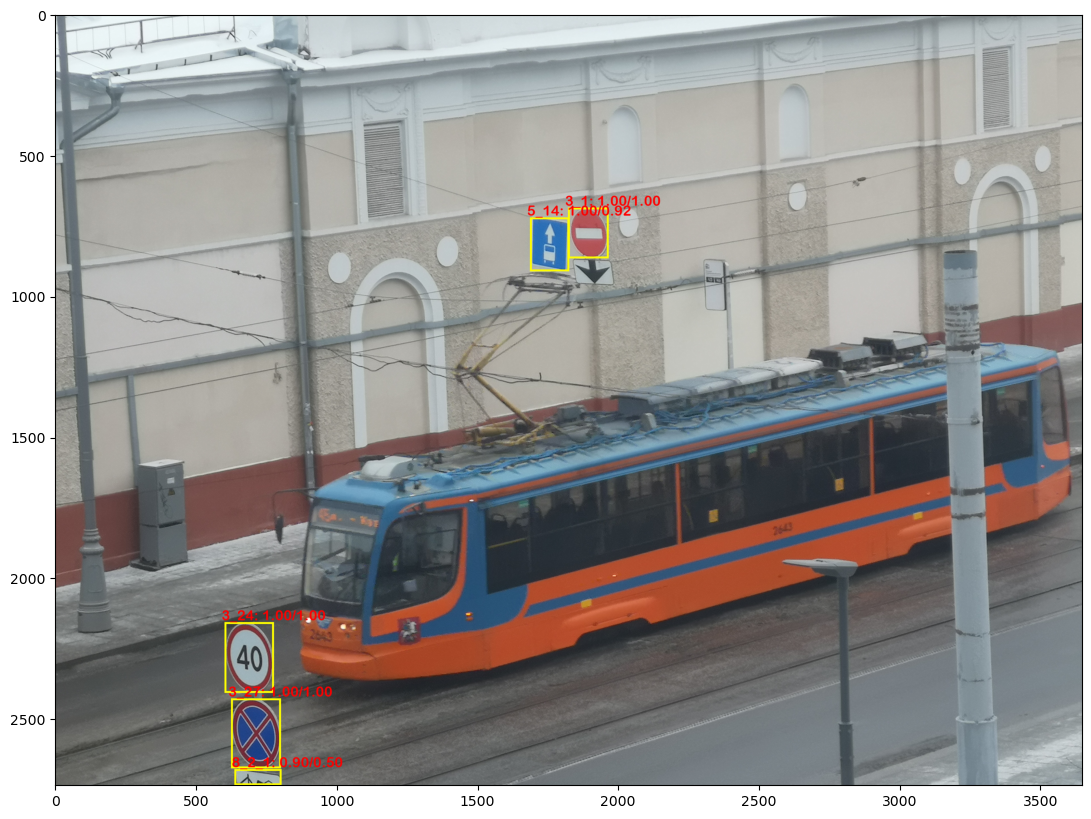

In [5]:
img_path = os.path.join('..','images','images_test','p20_8.jpg')
#img_path = cv2.imread(img_path)
img_pred, description = model.predict_single_visualized(img_path, display_img=True, save_path=None,
                                                        detector_threshold=None, classifier_threshold=None, debug_mode=True)

# TO DO
# Сделать режим выбора скора классификатор или детектор и классификатор
# Добавить переключалку режимов в predict single


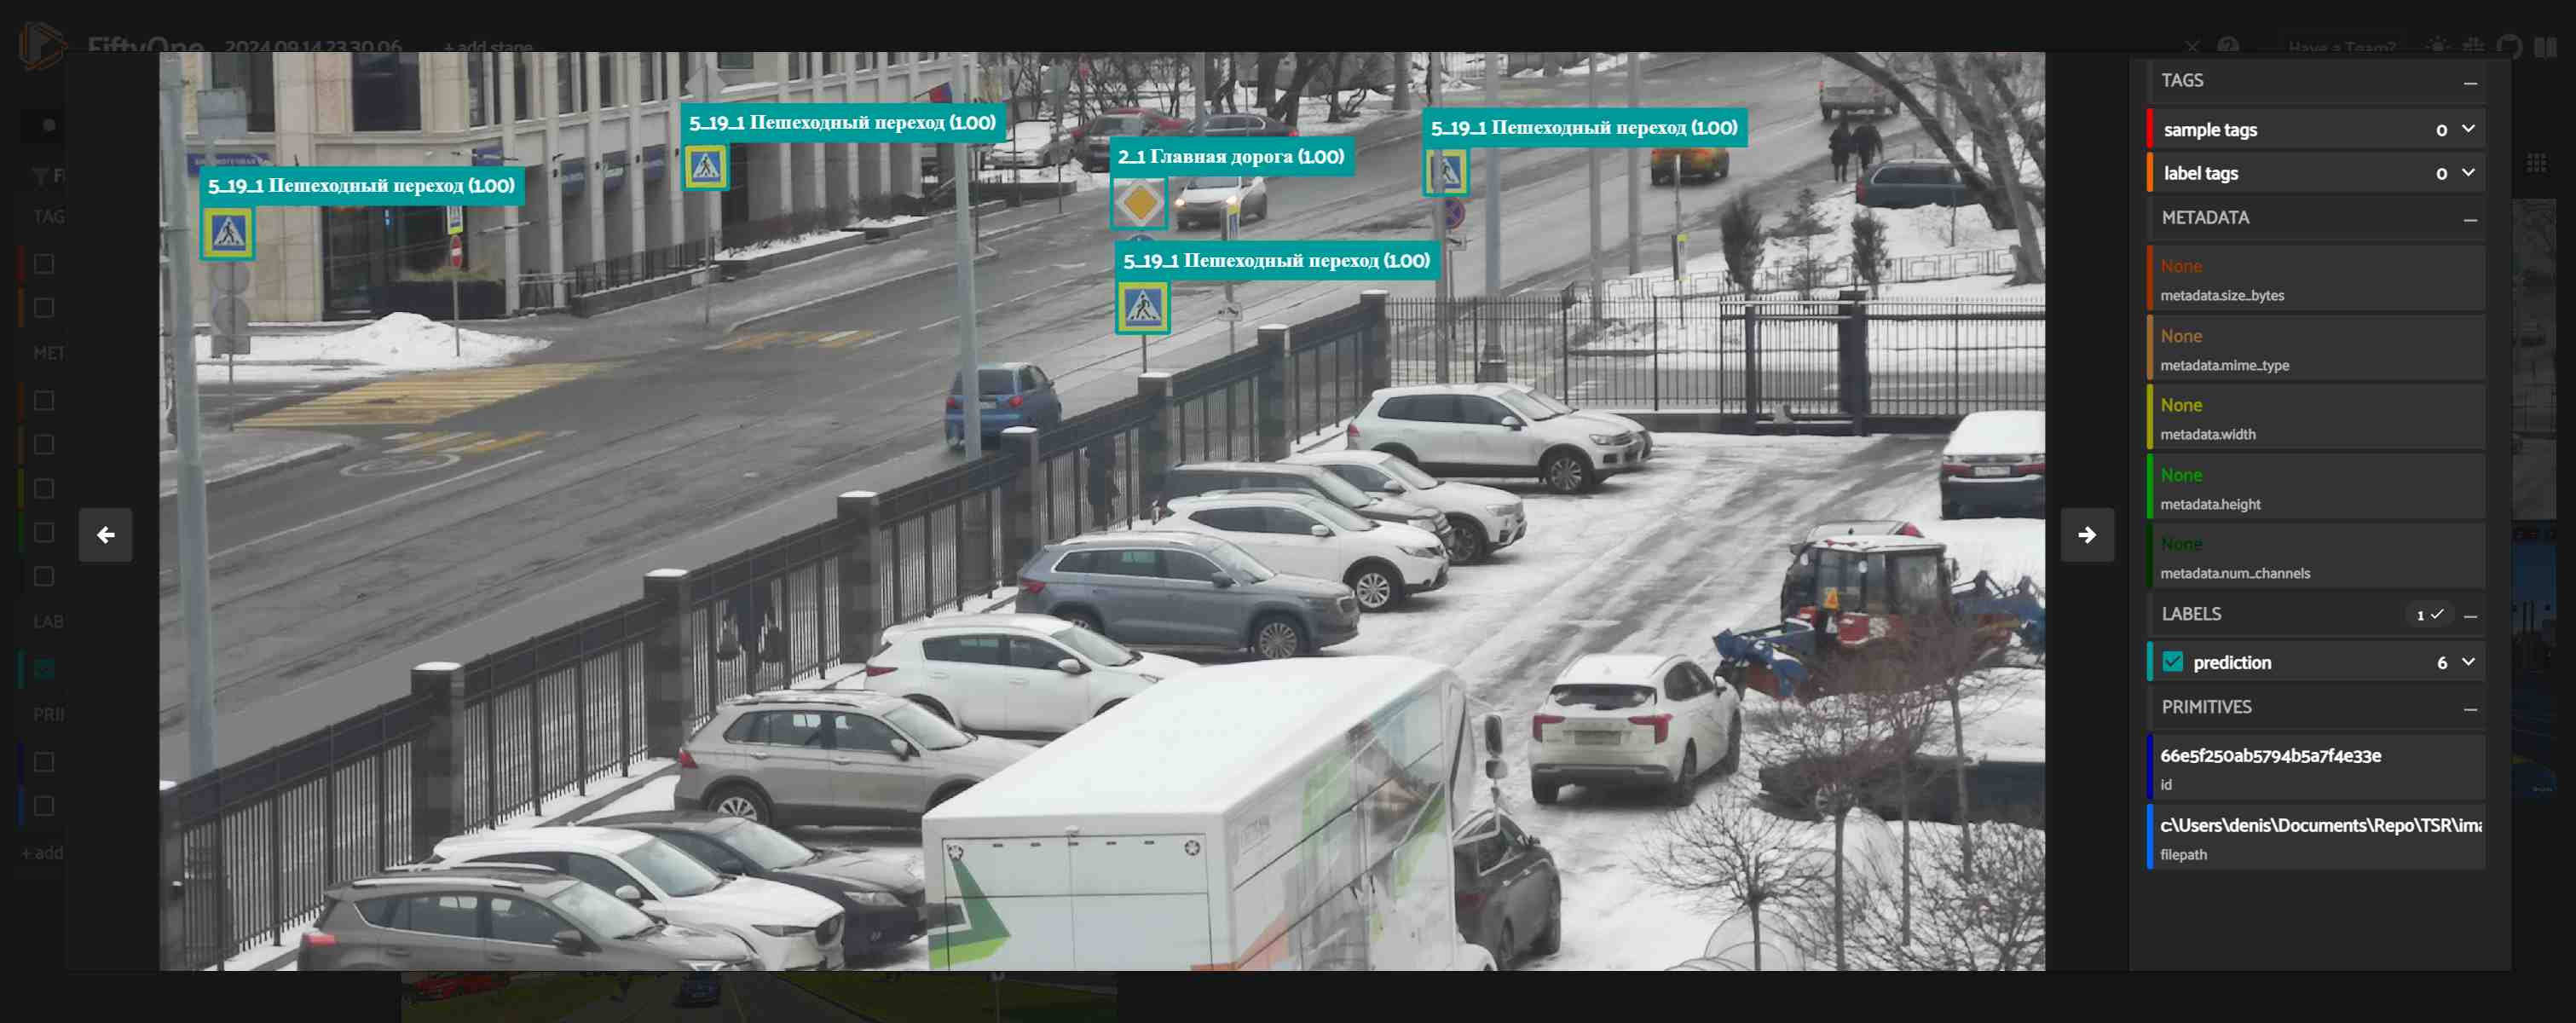

In [103]:
from PIL import Image
import fiftyone as fo

def predict_list_visualized(model, img_list: list, data_path: str = None,
                      detector_threshold: float = None, classifier_threshold: float = None, debug_mode: float = None):

    dataset = fo.Dataset()

    for img_path in img_list:       
        
        img = Image.open(img_path)
        h, w = img.height, img.width

        detections = []
        bboxes, pred_labels, pred_detector_scores, pred_classifier_scores = model.predict_single(img_path)
        for bbox, label, detector_score, classifier_score in zip(bboxes, pred_labels, pred_detector_scores, pred_classifier_scores):
            label_id = model.class2label_map[label]
            label_name = model.labels2names_map[label_id]
            x1, y1, x2, y2 = round(bbox[0]), round(bbox[1]), round(bbox[2]), round(bbox[3])
            rel_box = [x1/w, y1/h, (x2-x1)/w, (y2-y1)/h]          
            detections.append(fo.Detection(label=f'{label_id} {label_name}',
                                           bounding_box=rel_box,
                                           confidence=detector_score*classifier_score))
            
        sample = fo.Sample(filepath=img_path)  
        sample['prediction'] = fo.Detections(detections=detections)
        dataset.add_sample(sample)

    fo.launch_app(dataset)
        
    return None


img_list = [os.path.join('..', 'images', 'images_test', 'p20_1.jpg'),     # снимок из окна кабинета
            os.path.join('..', 'images', 'images_test', 'p20_2.jpg'),     # снимок из окна кабинета
            os.path.join('..', 'images', 'images_test', 'p20_3.jpg'),     # снимок из окна кабинета
            os.path.join('..', 'images', 'images_test', 'p20_4.jpg'),     # снимок из окна кабинета
            os.path.join('..', 'images', 'images_test', 'p20_5.jpg'),     # снимок из окна кабинета
            os.path.join('..', 'images', 'images_test', 'p20_6.jpg'),     # снимок из окна кабинета
            os.path.join('..', 'images', 'images_test', 'p20_7.jpg'),     # снимок из окна кабинета
            os.path.join('..', 'images', 'images_test', 'p20_8.jpg'),     # снимок из окна кабинета
            os.path.join('..', 'images', 'images_test', 'p20_9.jpg'),     # снимок из окна кабинета
            os.path.join('..', 'images', 'images_test', 'screen1.jpg'),   # скрин с яндекс карт
            os.path.join('..', 'images', 'images_test', 'screen2.jpg')]   # скрин с яндекс карт

predict_list_visualized(model, img_list, data_path=os.path.join('..', 'images', 'images_test'))

In [ ]:
images_dir = os.path.join('..', 'images', 'images_test')
predict_list_visualized(model, [os.path.join(images_dir, img) for img in os.listdir(images_dir)])

In [ ]:
def eval_detections(val_dataset, detector_file, classifier_file, threshold):
    # Add and evaluating Faster-RCNN detections
    # Faster-RCNN detections can be calculated and added to every sample of the dataset in a new field

    detector = torch.load(os.path.join(models_path, detector_file), map_location=device)
    classifier = torch.load(os.path.join(models_path, classifier_file), map_location=device)

    detector.eval()
    classifier.eval()
    
    classes = val_dataset.default_classes
   
    # Add predictions
    for i, sample in enumerate(val_dataset):
    
        image = Image.open(sample.filepath)
        image_tens = func.to_tensor(image).to(device)
        c,h,w = image_tens.shape

        # signs on image detection
        detect_preds = detector([image_tens])[0]
        detect_labels = detect_preds['labels'].cpu().detach().numpy()
        detect_scores = list(detect_preds['scores'].cpu().detach().numpy())
        detect_boxes = detect_preds['boxes'].cpu().detach().numpy()

        try:
            detect_tr = [detect_scores.index(x) for x in detect_scores if x > threshold][-1]
            
            detect_labels = detect_labels[:detect_tr+1]
            detect_boxes = detect_boxes[:detect_tr+1]
            detect_scores = detect_scores[:detect_tr+1]    
        except:
            detect_labels = []
            detect_boxes = []
            detect_scores = []

        detections = []
        for label, score, bbox in zip (detect_labels, detect_scores, detect_boxes):
                
            # bbox for crop
            sign_w = bbox[2] - bbox[0]
            sign_h = bbox[3] - bbox[1]
            x1 = round(max(bbox[0] - round(max((sign_w*0.1), 5)), 0))
            y1 = round(max(bbox[1] - round(max((sign_h*0.1), 5)), 0))
            x2 = round(min(bbox[2] + round(max((sign_w*0.1), 5)), w))
            y2 = round(min(bbox[3] + round(max((sign_h*0.1), 5)), h))
            bbox_for_crop = [x1, y1, x2, y2]

            # sign classification
            image_cropped1 = image.crop(bbox_for_crop)
            image_cropped = func.resize(image_cropped1, [224,224])
            image_cropped = func.to_tensor(image_cropped).to(device)
            classifier_label = int(np.argmax(classifier(image_cropped.unsqueeze(0)).data.cpu()))
            #classifier_label = classifier(image_cropped.unsqueeze(0)).data.max(1,keepdim=True)[1][0][0].cpu()
            if classifier_label != 0:
                label=classes[classifier_label]
                
                # Compute relative bounding box coordinates
                x1, y1, x2, y2 = bbox
                rel_box = [x1/w, y1/h, (x2-x1)/w, (y2-y1)/h]
                detections.append(fo.Detection(label=classes[classifier_label],
                                                bounding_box=rel_box,
                                                confidence=score
                                                )
                                    )
        sample['faster_rcnn'] = fo.Detections(detections=detections)
        sample.save()
            
        if i % 10 == 0:
            print(f"\tОбработано {i} из {val_dataset.__len__()} сэмплов.", end='\r')
    print(f"\tОбработано {val_dataset.__len__()} сэмплов." + ''*10)

    return None

In [ ]:
                # Compute relative bounding box coordinates
                x1, y1, x2, y2 = bbox
                rel_box = [x1/w, y1/h, (x2-x1)/w, (y2-y1)/h]
                detections.append(fo.Detection(label=classes[classifier_label],
                                                bounding_box=rel_box,
                                                confidence=score
                                                )
                                    )
        sample['faster_rcnn'] = fo.Detections(detections=detections)
        sample.save()

In [2]:
Список "images". Длина: 54188
{'id': 51,
 'width': 1280,
 'height': 720,
 'file_name': 'rtsd-frames/autosave01_02_2012_09_16_49.jpg'}
Список "annotations". Длина: 95492
{'id': 88,
 'image_id': 51,
 'category_id': 11,
 'area': 1813,
 'bbox': [826, 277, 37, 49],
 'iscrowd': 0}
Список "categories". Длина: 155
{'id': 11, 'name': '7_15'}

SyntaxError: invalid syntax (4156633869.py, line 1)

In [ ]:
 'width': 1280,
 'height': 720,
 'file_name': 'rtsd-frames/autosave01_02_2012_09_16_49.jpg'}

### Перенести detector_threshold: float = None, classifier_threshold: float = None, debug_mode: float = None в predict single

In [68]:
from PIL import Image

def predict_anno_coco(model, img_list: list, data_path: str = None,
                      detector_threshold: float = None, classifier_threshold: float = None, debug_mode: float = None):
    # TO DO разбить на путь к датасету и аннотации, определить место сохранения, сохранить аннотацию
    
    anno = {'images':[],
            'annotations':[],
            'categories':[[{'id': k}, {'name': v}] for k, v in model.class2label_map.items()]}
    if model.debug_mode == False:
        anno['categories'].pop(0) 
    
    for img_id, img_path in enumerate(img_list):
        
        # Исли указана папка с данными, образаем пути к изображениям
        if data_path:
            img_path, data_path = os.path.normpath(img_path), os.path.normpath(data_path)
            assert img_path[:len(data_path)] == data_path, 'Некорректно указаны пути к изображениям / каталогу с изображениями'
            file_name = img_path[len(data_path+os.sep):]
        else:
            file_name = img_path
        
        img = Image.open(img_path)
        anno['images'].append({'id': img_id,
                               'width': img.width,
                               'height': img.height,
                               'file_name': file_name})

        bboxes, pred_labels, pred_detector_scores, pred_classifier_scores = model.predict_single(img_path)

        for anno_id in range(len(bboxes)):
            
            x1, y1, x2, y2 = round(bboxes[anno_id][0]), round(bboxes[anno_id][1]), round(bboxes[anno_id][2]), round(bboxes[anno_id][3])
            width = x2 - x1
            height = y2 - y1

            anno['annotations'].append({'id': anno_id,
                                        'image_id': img_id,
                                        'category_id': pred_labels[anno_id],
                                        'area': width*height,
                                        'bbox': [x1, y1, width, height],
                                        'iscrowd': 0})
            
    return anno


img_list = [os.path.join('..', 'images', 'images_test', 'p20_1.jpg'),     # снимок из окна кабинета
            os.path.join('..', 'images', 'images_test', 'p20_2.jpg'),     # снимок из окна кабинета
            os.path.join('..', 'images', 'images_test', 'p20_3.jpg'),     # снимок из окна кабинета
            os.path.join('..', 'images', 'images_test', 'p20_4.jpg'),     # снимок из окна кабинета
            os.path.join('..', 'images', 'images_test', 'p20_5.jpg'),     # снимок из окна кабинета
            os.path.join('..', 'images', 'images_test', 'p20_6.jpg'),     # снимок из окна кабинета
            os.path.join('..', 'images', 'images_test', 'p20_7.jpg'),     # снимок из окна кабинета
            os.path.join('..', 'images', 'images_test', 'p20_8.jpg'),     # снимок из окна кабинета
            os.path.join('..', 'images', 'images_test', 'p20_9.jpg'),     # снимок из окна кабинета
            os.path.join('..', 'images', 'images_test', 'screen1.jpg'),   # скрин с яндекс карт
            os.path.join('..', 'images', 'images_test', 'screen2.jpg')]   # скрин с яндекс карт

prediction_anno = predict_anno_coco(model, img_list, data_path=os.path.join('..', 'images', 'images_test'))
prediction_anno

{'images': [{'id': 0, 'width': 3648, 'height': 2736, 'file_name': 'p20_1.jpg'},
  {'id': 1, 'width': 3648, 'height': 2736, 'file_name': 'p20_2.jpg'},
  {'id': 2, 'width': 3648, 'height': 2736, 'file_name': 'p20_3.jpg'},
  {'id': 3, 'width': 3648, 'height': 2736, 'file_name': 'p20_4.jpg'},
  {'id': 4, 'width': 3648, 'height': 2736, 'file_name': 'p20_5.jpg'},
  {'id': 5, 'width': 3648, 'height': 2736, 'file_name': 'p20_6.jpg'},
  {'id': 6, 'width': 3648, 'height': 2736, 'file_name': 'p20_7.jpg'},
  {'id': 7, 'width': 3648, 'height': 2736, 'file_name': 'p20_8.jpg'},
  {'id': 8, 'width': 3648, 'height': 2736, 'file_name': 'p20_9.jpg'},
  {'id': 9, 'width': 3735, 'height': 1522, 'file_name': 'screen1.jpg'},
  {'id': 10, 'width': 3749, 'height': 1521, 'file_name': 'screen2.jpg'}],
 'annotations': [{'id': 0,
   'image_id': 0,
   'category_id': 1,
   'area': 16002,
   'bbox': [2228, 1280, 127, 126],
   'iscrowd': 0},
  {'id': 1,
   'image_id': 0,
   'category_id': 7,
   'area': 15376,
   'bbox

In [69]:
import fiftyone as fo

In [ ]:
# Import the dataset
dataset = fo.Dataset.fr

In [ ]:
# Import the dataset
dataset = fo.Dataset.from_dir(
    dataset_type=fo.types.COCODetectionDataset,
    data_path=data_path,
    labels_path=labels_path)

In [ ]:
  
    with open(os.path.join(dataset_path, 'train_anno_reduced.json'), 'r') as read_file:
        categories = json.load(read_file)['categories']
    read_file.close()
    categories.insert(0, {'id': 0, 'name': '0'})
    anno['categories'] = categories


    result = predict

    with open(os.path.join(dataset_path, 'predicted_anno.json'), 'w') as f:
        json.dump(anno, f)#ensure_ascii=False, indent=4)
    f.close()

    # загрузка изображения в fiftyone
    data_path = images_path      # можно не указывать, если в JSON путь совпадает

    # The path yo the COCO labels JSON file
    labels_path = os.path.join(dataset_path, 'predicted_anno.json')


    # Import the dataset
    dataset = fo.Dataset.from_dir(
        dataset_type=fo.types.COCODetectionDataset,
        data_path=data_path,
        labels_path=labels_path
    )
    # Визуализация набора данных
    session = fo.launch_app(dataset)

In [ ]:
def eval_detections(val_dataset, detector_file, classifier_file, threshold):
    # Add and evaluating Faster-RCNN detections
    # Faster-RCNN detections can be calculated and added to every sample of the dataset in a new field

    detector = torch.load(os.path.join(models_path, detector_file), map_location=device)
    classifier = torch.load(os.path.join(models_path, classifier_file), map_location=device)

    detector.eval()
    classifier.eval()
    
    classes = val_dataset.default_classes
   
    # Add predictions
    for i, sample in enumerate(val_dataset):
    
        image = Image.open(sample.filepath)
        image_tens = func.to_tensor(image).to(device)
        c,h,w = image_tens.shape

        # signs on image detection
        detect_preds = detector([image_tens])[0]
        detect_labels = detect_preds['labels'].cpu().detach().numpy()
        detect_scores = list(detect_preds['scores'].cpu().detach().numpy())
        detect_boxes = detect_preds['boxes'].cpu().detach().numpy()

        try:
            detect_tr = [detect_scores.index(x) for x in detect_scores if x > threshold][-1]
            
            detect_labels = detect_labels[:detect_tr+1]
            detect_boxes = detect_boxes[:detect_tr+1]
            detect_scores = detect_scores[:detect_tr+1]    
        except:
            detect_labels = []
            detect_boxes = []
            detect_scores = []

        detections = []
        for label, score, bbox in zip (detect_labels, detect_scores, detect_boxes):
                
            # bbox for crop
            sign_w = bbox[2] - bbox[0]
            sign_h = bbox[3] - bbox[1]
            x1 = round(max(bbox[0] - round(max((sign_w*0.1), 5)), 0))
            y1 = round(max(bbox[1] - round(max((sign_h*0.1), 5)), 0))
            x2 = round(min(bbox[2] + round(max((sign_w*0.1), 5)), w))
            y2 = round(min(bbox[3] + round(max((sign_h*0.1), 5)), h))
            bbox_for_crop = [x1, y1, x2, y2]

            # sign classification
            image_cropped1 = image.crop(bbox_for_crop)
            image_cropped = func.resize(image_cropped1, [224,224])
            image_cropped = func.to_tensor(image_cropped).to(device)
            classifier_label = int(np.argmax(classifier(image_cropped.unsqueeze(0)).data.cpu()))
            #classifier_label = classifier(image_cropped.unsqueeze(0)).data.max(1,keepdim=True)[1][0][0].cpu()
            if classifier_label != 0:
                label=classes[classifier_label]
                
                # Compute relative bounding box coordinates
                x1, y1, x2, y2 = bbox
                rel_box = [x1/w, y1/h, (x2-x1)/w, (y2-y1)/h]
                detections.append(fo.Detection(label=classes[classifier_label],
                                                bounding_box=rel_box,
                                                confidence=score
                                                )
                                    )
        sample['faster_rcnn'] = fo.Detections(detections=detections)
        sample.save()
            
        if i % 10 == 0:
            print(f"\tОбработано {i} из {val_dataset.__len__()} сэмплов.", end='\r')
    print(f"\tОбработано {val_dataset.__len__()} сэмплов." + ''*10)

    return None

In [ ]:
pred_boxes, pred_labels, pred_scores = get_prediction_one_image(images_path, img_name, threshold)
    anno = {}

    images = []
    image_item = {}
    image_item['id'] = 0
    img = Image.open(os.path.join(images_path, img_name))
    transforms=torchvision.transforms.ToTensor()
    img = transforms(img).to(device)
    image_item['width'] = img.shape[2]
    image_item['height'] = img.shape[1]
    image_item['file_name'] = img_name
    images.append(image_item)
    anno['images'] = images

    annotations = []
    for i in range(len(pred_boxes)):
        anno_item = {}
        anno_item['id'] = i
        anno_item['image_id'] = 0
        anno_item['category_id'] = int(pred_labels[i])
        anno_item['area'] = (float(pred_boxes[i][2]) - float(pred_boxes[i][0]))*(float(pred_boxes[i][3]) - float(pred_boxes[i][1]))     # Исправить, так как COCO формат
        anno_item['bbox'] = [float(pred_boxes[i][0]), float(pred_boxes[i][1]), float(pred_boxes[i][2]) - float(pred_boxes[i][0]), float(pred_boxes[i][3]) - float(pred_boxes[i][1])]
        anno_item['iscrowd'] = 0
        annotations.append(anno_item)
    anno['annotations'] = annotations
    
    anno['categories'] = [{'id': 1, 'name': 'sign'}]

    with open(os.path.join(dataset_path, 'predicted_anno.json'), 'w') as f:
        json.dump(anno, f)#ensure_ascii=False, indent=4)
    f.close()

    # загрузка изображения в fiftyone
    data_path = images_path      # можно не указывать, если в JSON путь совпадает

    # The path yo the COCO labels JSON file
    labels_file = "train_anno_bin_class.json"
    labels_path = os.path.join(dataset_path, 'predicted_anno.json')


    # Import the dataset
    dataset = fo.Dataset.from_dir(
        dataset_type=fo.types.COCODetectionDataset,
        data_path=data_path,
        labels_path=labels_path
    )
    # Визуализация набора данных
    session = fo.launch_app(dataset)

In [ ]:
# функция еще не готова
# формирование аннотации
def get_predict_anno(images_path, img_name, threshold):

    if img_name == None:
        with open(os.path.join(dataset_path, 'val_anno.json'), 'r') as read_file:
            val_anno = json.load(read_file)
        read_file.close()
        img_name = val_anno.get('images')[random.randint(0, len(val_anno.get('images')))].get('file_name')

    pred_boxes, pred_labels, pred_scores = get_prediction_one_image(images_path, img_name, threshold)
    anno = {}

    images = []
    image_item = {}
    image_item['id'] = 0
    img = Image.open(os.path.join(images_path, img_name))
    transforms=torchvision.transforms.ToTensor()
    img = transforms(img).to(device)
    image_item['width'] = img.shape[2]
    image_item['height'] = img.shape[1]
    image_item['file_name'] = img_name
    images.append(image_item)
    anno['images'] = images

    annotations = []
    for i in range(len(pred_boxes)):
        anno_item = {}
        anno_item['id'] = i
        anno_item['image_id'] = 0
        anno_item['category_id'] = int(pred_labels[i])
        anno_item['area'] = (float(pred_boxes[i][2]) - float(pred_boxes[i][0]))*(float(pred_boxes[i][3]) - float(pred_boxes[i][1]))     # Исправить, так как COCO формат
        anno_item['bbox'] = [float(pred_boxes[i][0]), float(pred_boxes[i][1]), float(pred_boxes[i][2]) - float(pred_boxes[i][0]), float(pred_boxes[i][3]) - float(pred_boxes[i][1])]
        anno_item['iscrowd'] = 0
        annotations.append(anno_item)
    anno['annotations'] = annotations
    
    anno['categories'] = [{'id': 1, 'name': 'sign'}]

    with open(os.path.join(dataset_path, 'predicted_anno.json'), 'w') as f:
        json.dump(anno, f)#ensure_ascii=False, indent=4)
    f.close()

    # загрузка изображения в fiftyone
    data_path = images_path      # можно не указывать, если в JSON путь совпадает

    # The path yo the COCO labels JSON file
    labels_file = "train_anno_bin_class.json"
    labels_path = os.path.join(dataset_path, 'predicted_anno.json')


    # Import the dataset
    dataset = fo.Dataset.from_dir(
        dataset_type=fo.types.COCODetectionDataset,
        data_path=data_path,
        labels_path=labels_path
    )
    # Визуализация набора данных
    session = fo.launch_app(dataset)

    return anno

# Разбор с предыдущего

NameError: name 'get_prediction_one_image' is not defined

In [ ]:
def get_predict_anno(images_path, img_name, threshold):

    if img_name == None:
        with open(os.path.join(dataset_path, 'val_anno.json'), 'r') as read_file:
            val_anno = json.load(read_file)
        read_file.close()
        img_name = val_anno.get('images')[random.randint(0, len(val_anno.get('images')))].get('file_name')

    _, pred_boxes, pred_labels, pred_scores = get_prediction_one_image(images_path, img_name, threshold)
    
    anno = {}

    images = []
    image_item = {}
    image_item['id'] = 0
    img = Image.open(os.path.join(images_path, img_name))
    transforms=torchvision.transforms.ToTensor()
    img = transforms(img).to(device)
    image_item['width'] = img.shape[2]
    image_item['height'] = img.shape[1]
    image_item['file_name'] = img_name
    images.append(image_item)
    anno['images'] = images

    annotations = []
    for i in range(len(pred_boxes)):
        anno_item = {}
        anno_item['id'] = i
        anno_item['image_id'] = 0
        anno_item['category_id'] = int(pred_labels[i])
        anno_item['area'] = (float(pred_boxes[i][2]) - float(pred_boxes[i][0]))*(float(pred_boxes[i][3]) - float(pred_boxes[i][1]))     # Исправить, так как COCO формат
        anno_item['bbox'] = [float(pred_boxes[i][0]), float(pred_boxes[i][1]), float(pred_boxes[i][2]) - float(pred_boxes[i][0]), float(pred_boxes[i][3]) - float(pred_boxes[i][1])]
        anno_item['iscrowd'] = 0
        annotations.append(anno_item)
    anno['annotations'] = annotations
    
    with open(os.path.join(dataset_path, 'train_anno_reduced.json'), 'r') as read_file:
        categories = json.load(read_file)['categories']
    read_file.close()
    categories.insert(0, {'id': 0, 'name': '0'})
    anno['categories'] = categories

    with open(os.path.join(dataset_path, 'predicted_anno.json'), 'w') as f:
        json.dump(anno, f)#ensure_ascii=False, indent=4)
    f.close()

    # загрузка изображения в fiftyone
    data_path = images_path      # можно не указывать, если в JSON путь совпадает

    # The path yo the COCO labels JSON file
    labels_file = "train_anno_bin_class.json"
    labels_path = os.path.join(dataset_path, 'predicted_anno.json')


    # Import the dataset
    dataset = fo.Dataset.from_dir(
        dataset_type=fo.types.COCODetectionDataset,
        data_path=data_path,
        labels_path=labels_path
    )
    # Визуализация набора данных
    session = fo.launch_app(dataset)

    return anno

In [ ]:
threshold = 0.5
#img_name = None
img_name = 'image_for_predict/p20_5.jpg'
#img_name = 'rtsd-frames/autosave16_10_2012_08_58_25_5.jpg'
#img_name = 'rtsd-frames/autosave01_02_2012_09_24_03.jpg'
#prediction_anno = get_predict_anno(dataset_path, , threshold)
prediction_anno = get_predict_anno(dataset_path, img_name, threshold)

### Детекция знаков на списке изображений


In [ ]:
def get_prediction_list_images(images_path, img_list, threshold):
    detector.eval()
    transforms=torchvision.transforms.ToTensor()
    images = []
    for image in img_list:
        img = Image.open(os.path.join(images_path, image)) 
        img = transforms(img).to(device)
        images.append(img)
            
    predictions = detector(images)
    
    results = []
    for prediction in predictions:
        result = []
        pred_boxes = [[i[0], i[1], i[2], i[3]] for i in list(prediction['boxes'].detach().cpu().numpy())]
        pred_labels = list(prediction.get('labels').cpu().numpy())
        pred_scores = list(prediction.get('scores').detach().cpu().numpy())

        pred_tr = [pred_scores.index(x) for x in pred_scores if x > threshold][-1]
        pred_labels = pred_labels[:pred_tr+1]
        pred_boxes = pred_boxes[:pred_tr+1]
        pred_scores = pred_scores[:pred_tr+1]
        result.append(pred_boxes)
        result.append(pred_labels)
        result.append(pred_scores)
        results.append(result)
    #boxes = []
    #for i in range(num_objs):
    #    min = coco_annotation[i]['bbox'][0]
    #    ymin = coco_annotation[i]['bbox'][1]
    #    xmax = xmin + coco_annotation[i]['bbox'][2]
    #    ymax = ymin + coco_annotation[i]['bbox'][3]
    #    boxes.append([xmin, ymin, xmax, ymax])
    
    return results#pred_boxes, pred_labels, pred_scores

time_start = time.time()
img_list = ['rtsd-frames/autosave16_10_2012_08_58_25_5.jpg',
            'rtsd-frames/autosave01_02_2012_09_24_03.jpg']
threshold = 0.1
prediction = get_prediction_list_images(dataset_path, img_list, threshold)
time_end = time.time()
prediction, time_end-time_start

In [ ]:
def get_predict_anno_list_images(images_path, img_list, threshold):

    if img_list == None:
        with open(os.path.join(dataset_path, 'val_anno.json'), 'r') as read_file:
            val_anno = json.load(read_file)
        read_file.close()
        img_list = [val_anno.get('images')[random.randint(0, len(val_anno.get('images')))].get('file_name')]

    predict = []
    for image in img_list:
        one_predict = get_prediction_one_image(dataset_path, image, threshold)
        predict.append(one_predict)
    anno = {}
    anno_item_id = 0

    transforms=torchvision.transforms.ToTensor()
    images = []
    annotations = []
    for i in range(len(predict)):
        img = Image.open(os.path.join(images_path, img_list[i]))
        img = transforms(img).to(device)
        
        image_item = {}
        image_item['id'] = i
        image_item['width'] = img.shape[2]
        image_item['height'] = img.shape[1]
        image_item['file_name'] = img_list[i]
        images.append(image_item)

        prediction = predict[i]
        #for j in range(len(prediction[0])):
        for j in range(len(prediction[1])):
            
            anno_item = {}
            anno_item['id'] = anno_item_id
            anno_item_id += 1
            anno_item['image_id'] = i
            #anno_item['category_id'] = int(prediction[1][j])
            anno_item['category_id'] = int(prediction[2][j])
            #anno_item['area'] = (float(prediction[0][j][2]) - float(prediction[0][j][0]))*(float(prediction[0][j][3]) - float(prediction[0][j][1]))
            anno_item['area'] = (float(prediction[1][j][2]) - float(prediction[1][j][0]))*(float(prediction[1][j][3]) - float(prediction[1][j][1]))
            #anno_item['bbox'] = [float(prediction[0][j][0]), float(prediction[0][j][1]), float(prediction[0][j][2]) - float(prediction[0][j][0]), float(prediction[0][j][3]) - float(prediction[0][j][1])]
            anno_item['bbox'] = [float(prediction[1][j][0]), float(prediction[1][j][1]), float(prediction[1][j][2]) - float(prediction[1][j][0]), float(prediction[1][j][3]) - float(prediction[1][j][1])]
            anno_item['iscrowd'] = 0
            annotations.append(anno_item)
    
    anno['images'] = images
    anno['annotations'] = annotations
    
    with open(os.path.join(dataset_path, 'train_anno_reduced.json'), 'r') as read_file:
        categories = json.load(read_file)['categories']
    read_file.close()
    categories.insert(0, {'id': 0, 'name': '0'})
    anno['categories'] = categories


    result = predict

    with open(os.path.join(dataset_path, 'predicted_anno.json'), 'w') as f:
        json.dump(anno, f)#ensure_ascii=False, indent=4)
    f.close()

    # загрузка изображения в fiftyone
    data_path = images_path      # можно не указывать, если в JSON путь совпадает

    # The path yo the COCO labels JSON file
    labels_path = os.path.join(dataset_path, 'predicted_anno.json')


    # Import the dataset
    dataset = fo.Dataset.from_dir(
        dataset_type=fo.types.COCODetectionDataset,
        data_path=data_path,
        labels_path=labels_path
    )
    # Визуализация набора данных
    session = fo.launch_app(dataset)

    return result#annotations


threshold = 0
img_list = ['image_for_predict/image1.jpg',                     # картинка из интернета
            'image_for_predict/image2.jpg',                     # картинка из интернета
            'image_for_predict/screen1.jpg',                    # скрин я яндекс карт
            'image_for_predict/screen2.jpg',                    # скрин я яндекс карт
            'image_for_predict/p20_1.jpg',                      # снимок из окна кабинета
            'image_for_predict/p20_2.jpg',                      # снимок из окна кабинета
            'image_for_predict/p20_3.jpg',                      # снимок из окна кабинета
            'image_for_predict/p20_4.jpg',                      # снимок из окна кабинета
            'image_for_predict/p20_5.jpg',                      # снимок из окна кабинета
            'image_for_predict/p20_6.jpg',                      # снимок из окна кабинета
            'image_for_predict/p20_7.jpg',                      # снимок из окна кабинета
            'image_for_predict/p20_8.jpg',                      # снимок из окна кабинета
            'image_for_predict/p20_9.jpg',                      # снимок из окна кабинета
            'rtsd-frames/autosave16_10_2012_08_58_25_5.jpg',    # тестовая выборка
            'rtsd-frames/autosave01_02_2012_09_24_03.jpg'       # тестовая выборка 
            ]

#prediction_anno = get_predict_anno_list_images(dataset_path, None, threshold)
prediction_anno = get_predict_anno_list_images(dataset_path, img_list, threshold=0.9)
prediction_anno

In [ ]:
#Load val dataset COCO
# загрузка датасета
import fiftyone as fo
# The directiry containing the source images
data_path = dataset_path      # можно не указывать, если в JSON путь совпадает

# The path yo the COCO labels JSON file
val_anno_file = "val_anno_bin_class.json"
val_anno_path = os.path.join(dataset_path, val_anno_file)


# Import the dataset
val_dataset = fo.Dataset.from_dir(
    dataset_type=fo.types.COCODetectionDataset,
    data_path=data_path,
    labels_path=val_anno_path
)

In [ ]:
predictions_view = val_dataset.take(50, seed=42)

In [ ]:
# Add and evaluating Faster-RCNN detections
# Faster-RCNN detections can be calculated and added to every sample of the dataset in a new field
import torch, torchvision
from torchvision.transforms import functional as func
import json
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image

# Load the pretrained PyTorch model
def load_model_detection(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model =torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=None)
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

num_classes = 2
model = load_model_detection(num_classes)

# Run the model on GPU if it is available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Загрузка весов модели
checkpoint = torch.load('checkpoints/chkpt_detector_resnet50_augmented_2.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

classes = predictions_view.default_classes

# Add predictions
n=0
for sample in predictions_view:
    image = Image.open(sample.filepath)
    image = func.to_tensor(image).to(device)
    c,h,w = image.shape
    preds = model([image])[0]
    labels = preds['labels'].cpu().detach().numpy()
    scores = preds['scores'].cpu().detach().numpy()
    boxes = preds['boxes'].cpu().detach().numpy()
    detections = []
    for label, score, box in zip (labels, scores, boxes):
        # Compute relative bounding box coordinates
        x1, y1, x2, y2 = box
        rel_box = [x1/w, y1/h, (x2-x1)/w, (y2-y1)/h]
        detections.append(fo.Detection(label=classes[label],
                                        bounding_box=rel_box,
                                        confidence=score
                                        )
                            )
    sample['faster_rcnn'] = fo.Detections(detections=detections)
    sample.save()